In [1]:
import os
print(os.listdir("../input"))

['zindi-calls', 'zindi-calls-test']


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd

In [3]:
train=pd.read_csv("../input/zindi-calls/train.csv")
test=pd.read_csv("../input/zindi-calls-test/Sample_Submission (2).csv")
weather = pd.read_excel('../input/zindi-calls/WeatherNairobi2016.xls',skiprows=6)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (12,13,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train.head().T

,0,1,2,3,4
calldate,2016-01-01 07:26:47,2016-01-01 07:32:30,2016-01-01 07:44:31,2016-01-01 07:46:13,2016-01-01 07:47:22
cc_status,Closed,Closed,Closed,Closed,Closed
maincat,non-interventional,non-interventional,non-interventional,others,non-interventional
subcat1,Blank call,Blank call,Blank call,Unrelated to remit of Childline 116,Blank call
casepriority,Non Critical,Non Critical,Non Critical,Non Critical,Non Critical
referal,NaN,NaN,NaN,NaN,NaN
caller_gender,NaN,NaN,NaN,Male,NaN
caller_age,NaN,NaN,NaN,Adult,NaN
caller_county,NaN,NaN,NaN,Nyeri,NaN
child_age,NaN,NaN,NaN,NaN,NaN


In [5]:
weather.head(10)

,Local time in Nairobi (airport),T,Po,P,Pa,U,DD,Ff,ff10,ff3,N,WW,W1,W2,Tn,Tx,Cl,Nh,H,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,31.12.2016 21:00,20.2,NaN,NaN,NaN,68.0,Wind blowing from the east-northeast,8.0,NaN,NaN,70 – 80%.,,NaN,NaN,NaN,27.5,Stratocumulus other than Stratocumulus cumulog...,60%.,600-1000,Altocumulus translucidus at a single level.,"No Cirrus, Cirrocumulus or Cirrostratus.",30.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
1,31.12.2016 15:00,26.0,NaN,NaN,NaN,40.0,Wind blowing from the north-east,9.0,NaN,NaN,40%.,,NaN,NaN,NaN,NaN,"Cumulonimbus capillatus (often with an anvil),...",40%.,600-1000,"No Altocumulus, Altostratus or Nimbostratus.","No Cirrus, Cirrocumulus or Cirrostratus.",30.0,11.2,NaN,NaN,NaN,NaN,NaN,NaN
2,31.12.2016 09:00,18.8,NaN,NaN,NaN,85.0,Wind blowing from the north-northeast,5.0,NaN,NaN,60%.,,NaN,NaN,NaN,NaN,Stratocumulus other than Stratocumulus cumulog...,40%.,300-600,Altocumulus translucidus at a single level.,"No Cirrus, Cirrocumulus or Cirrostratus.",25.0,16.2,Trace of precipitation,24.0,NaN,NaN,NaN,NaN
3,30.12.2016 21:00,19.5,NaN,NaN,NaN,79.0,Wind blowing from the east-northeast,4.0,NaN,NaN,40%.,,NaN,NaN,NaN,26.9,Stratocumulus cumulogenitus.,40%.,600-1000,Altocumulus translucidus at a single level.,"No Cirrus, Cirrocumulus or Cirrostratus.",20.0,15.8,NaN,NaN,NaN,NaN,NaN,NaN
4,30.12.2016 15:00,24.5,NaN,NaN,NaN,56.0,Wind blowing from the east-northeast,7.0,NaN,NaN,70 – 80%.,,NaN,NaN,NaN,NaN,"Cumulonimbus capillatus (often with an anvil),...",40%.,600-1000,Altocumulus translucidus at a single level.,Cirrus spissatus cumulonimbogenitus.,30.0,15.1,NaN,NaN,NaN,NaN,NaN,NaN
5,30.12.2016 09:00,18.6,NaN,NaN,NaN,90.0,Wind blowing from the east-northeast,1.0,NaN,NaN,"90 or more, but not 100%",,NaN,NaN,16.7,NaN,Cumulus and Stratocumulus other than Stratocum...,60%.,300-600,Altocumulus translucidus at a single level.,NaN,30.0,16.9,1,24.0,NaN,NaN,NaN,NaN
6,30.12.2016 03:00,17.4,NaN,NaN,NaN,79.0,Wind blowing from the north-east,5.0,NaN,NaN,"10% or less, but not 0",,NaN,NaN,NaN,NaN,Stratocumulus other than Stratocumulus cumulog...,"10% or less, but not 0",300-600,"No Altocumulus, Altostratus or Nimbostratus.","No Cirrus, Cirrocumulus or Cirrostratus.",30.0,13.6,NaN,NaN,NaN,NaN,NaN,NaN
7,29.12.2016 21:00,21.8,NaN,NaN,NaN,65.0,Wind blowing from the east-northeast,5.0,NaN,NaN,"90 or more, but not 100%",,NaN,NaN,NaN,27.4,Stratocumulus other than Stratocumulus cumulog...,"90 or more, but not 100%",600-1000,NaN,NaN,30.0,14.8,NaN,NaN,NaN,NaN,NaN,NaN
8,29.12.2016 15:00,27.2,NaN,NaN,NaN,44.0,Wind blowing from the east,5.0,NaN,NaN,70 – 80%.,,NaN,NaN,NaN,NaN,"Cumulonimbus capillatus (often with an anvil),...","10% or less, but not 0",600-1000,Altostratus opacus or Nimbostratus.,NaN,30.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
9,29.12.2016 09:00,19.8,NaN,NaN,NaN,76.0,Wind blowing from the north,3.0,NaN,NaN,"90 or more, but not 100%",,NaN,NaN,15.4,NaN,Stratocumulus other than Stratocumulus cumulog...,50%.,300-600,Altocumulus translucidus at a single level.,NaN,30.0,15.4,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train.shape

(135988, 19)

In [7]:
train['calldate']=pd.to_datetime(train['calldate'])

In [8]:
def transform(x):
    if len(x)!=2:
        a='0'+x
    else:
        a=x
    return a

In [9]:
train['Year']=train['calldate'].dt.year.astype('str')
train['Month']=train['calldate'].dt.month.astype('str').apply(transform)
train['Day']=train['calldate'].dt.day.astype('str').apply(transform)
train['Hour']=train['calldate'].dt.hour.astype('str').apply(transform)

In [10]:
train['Date']=train['Year']+train['Month']+train['Day']+train['Hour']

In [11]:
train_new=pd.DataFrame(train.groupby('Date').count()['calldate']).reset_index(level=0)

In [12]:
train_new['calls']=train_new['calldate']
del train_new['calldate']

train_new.head()

,Date,calls
0,2016010107,8
1,2016010108,41
2,2016010109,20
3,2016010110,34
4,2016010111,44


In [13]:
def month(x):
    a=x[4:6]
    return a

def day(x):
    a=x[6:8]
    return a

def hour(x):
    a=x[8:]
    return a

In [14]:
train_new['Month']=train_new['Date'].apply(month)
train_new['Day']=train_new['Date'].apply(day)
train_new['hour']=train_new['Date'].apply(hour)

In [15]:
test.head()

,time_index,calls
0,2016071300,28.0
1,2016071301,98.0
2,2016071302,NaN
3,2016071303,NaN
4,2016071304,NaN


In [16]:
test['Month']=test['time_index'].astype('str').apply(month)
test['Day']=test['time_index'].astype('str').apply(day)
test['hour']=test['time_index'].astype('str').apply(hour)

In [17]:
train_new.head()

,Date,calls,Month,Day,hour
0,2016010107,8,01,01,07
1,2016010108,41,01,01,08
2,2016010109,20,01,01,09
3,2016010110,34,01,01,10
4,2016010111,44,01,01,11


In [18]:
del test['calls']
test.head()

,time_index,Month,Day,hour
0,2016071300,07,13,00
1,2016071301,07,13,01
2,2016071302,07,13,02
3,2016071303,07,13,03
4,2016071304,07,13,04


In [23]:
from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries,lag=12):
    #Determing rolling statistics    
    rolmean = timeseries.rolling(window=lag).mean()    
    rolstd = timeseries.rolling(window=lag).std()   
    #Plot rolling statistics:    
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')    
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')    
    plt.legend(loc='best')    
    plt.title('Rolling Mean & Standard Deviation')    
    plt.show(block=False)        
    #Perform Dickey-Fuller test:    
    print ('Results of Dickey-Fuller Test:')    
    result = adfuller(timeseries, autolag='AIC')   
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    print('There is a ',round(result[1]*100,4),'% chance that my process is non stationary')
    print('Alternatively, There is a ',100-round(result[1]*100,4),'% chance that my process is stationary')

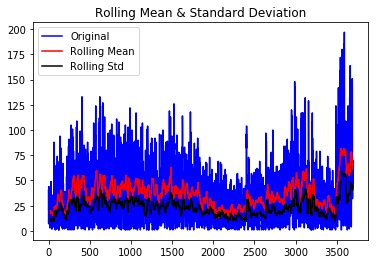

Results of Dickey-Fuller Test:
ADF Statistic: -5.297578
p-value: 0.000006
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
There is a  0.0006 % chance that my process is non stationary
Alternatively, There is a  99.9994 % chance that my process is stationary


In [24]:
test_stationarity(train_new['calls'],24)

In [25]:
train_new['target']=train_new['calls'].shift(-1)
#train_new['three hours rolling']=train_new['calldate'].rolling(window=3).mean()
#train_new['six hours rolling']=train_new['calldate'].rolling(window=6).mean()
#train_new['twelve hours rolling']=train_new['calldate'].rolling(window=12).mean()
#train_new['twenty-fours hours rolling']=train_new['calldate'].rolling(window=24).mean()
#train_new['three days rolling']=train_new['calldate'].rolling(window=72).mean()

train_new.dropna(inplace=True)

In [26]:
train_new.head()

,Date,calls,Month,Day,hour,target
0,2016010107,8,01,01,07,41.0
1,2016010108,41,01,01,08,20.0
2,2016010109,20,01,01,09,34.0
3,2016010110,34,01,01,10,44.0
4,2016010111,44,01,01,11,27.0


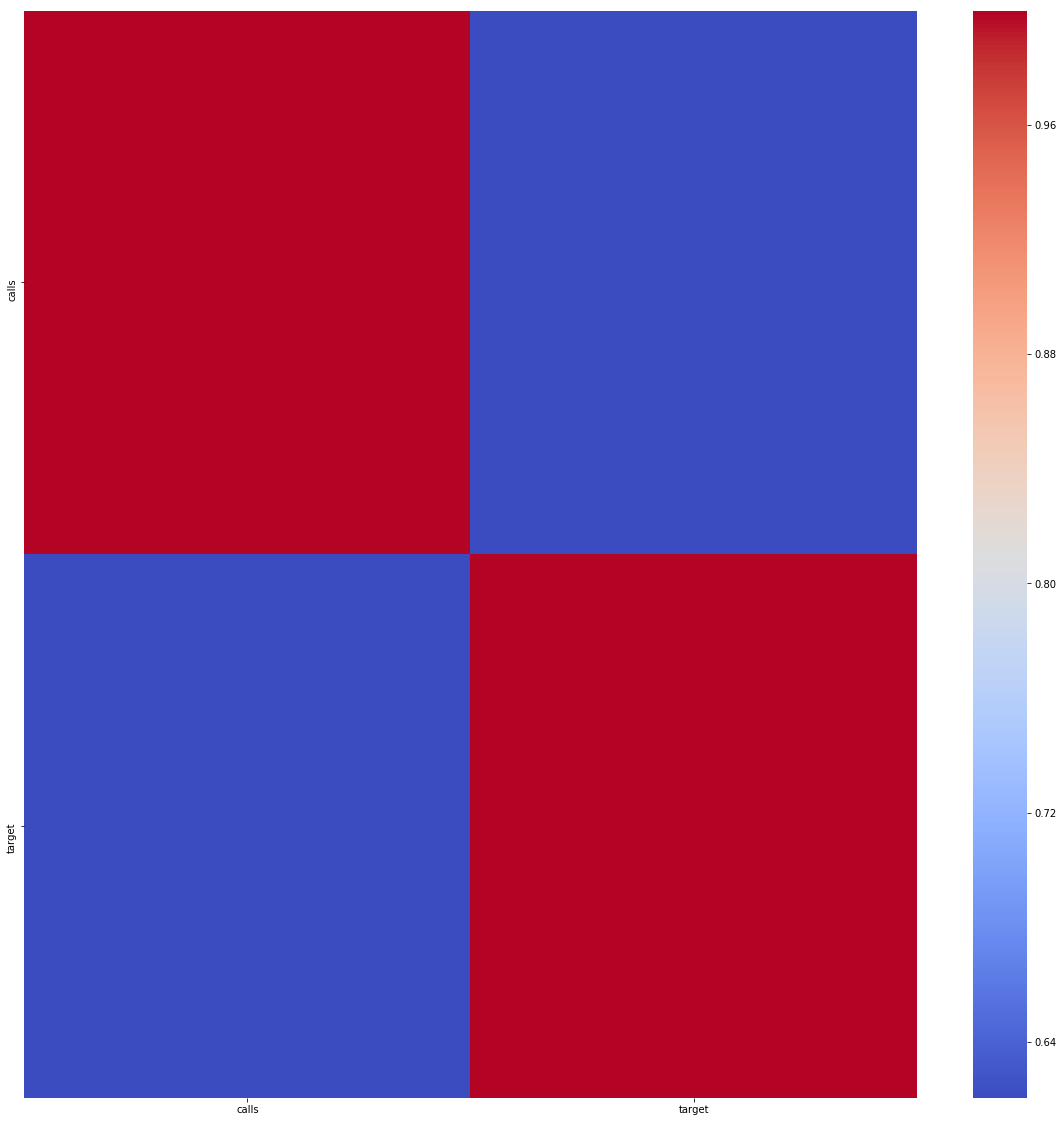

In [27]:
plt.figure(figsize=(20,20))
sns.heatmap(train_new.corr(),cmap='coolwarm')

In [28]:
from catboost import CatBoostRegressor

In [38]:
X=train_new.drop(['target','Date','Month','calls'],axis=1)
y=train_new['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

In [39]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()

In [40]:
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [41]:
from catboost import CatBoostRegressor

In [42]:
cb=CatBoostRegressor(iterations=2000,learning_rate=0.1,depth=5,use_best_model=True,random_seed=12,eval_metric='RMSE')

In [43]:
cb.fit(X_train,y_train,use_best_model=True,eval_set=(X_test,y_test),verbose=50, early_stopping_rounds=50)

0:	learn: 39.9071373	test: 53.8374316	best: 53.8374316 (0)	total: 4.3ms	remaining: 8.6s
50:	learn: 19.5928117	test: 32.0922551	best: 32.0922551 (50)	total: 151ms	remaining: 5.76s
100:	learn: 19.1030093	test: 31.6800034	best: 31.6716318 (97)	total: 299ms	remaining: 5.63s
150:	learn: 18.9191017	test: 31.5000163	best: 31.5000163 (150)	total: 446ms	remaining: 5.46s
200:	learn: 18.7936375	test: 31.4247488	best: 31.4140806 (194)	total: 588ms	remaining: 5.26s
250:	learn: 18.7255347	test: 31.3786818	best: 31.3783497 (249)	total: 725ms	remaining: 5.05s
300:	learn: 18.6612036	test: 31.3413828	best: 31.3182636 (296)	total: 869ms	remaining: 4.91s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 31.31826362
bestIteration = 296

Shrink model to first 297 iterations.


Text(0.5, 0, 'Importance')

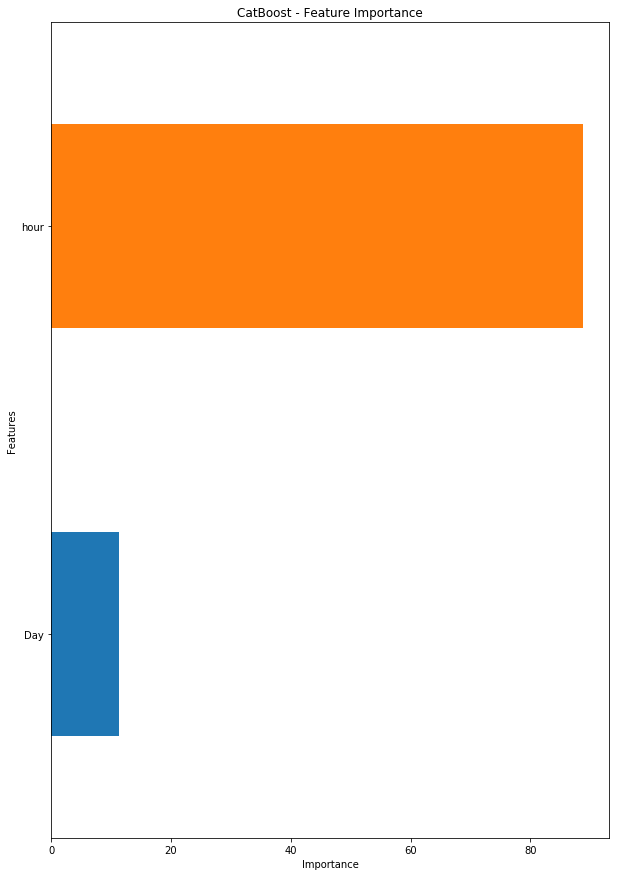

In [44]:
fea_imp = pd.DataFrame({'imp': cb.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 15), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [46]:
df=pd.DataFrame(np.round(cb.predict(sc.transform(test.drop(['time_index','Month'],axis=1))),0))
df.to_csv('mycsvfile2.csv',index=False)
